# General idea:
input missing and replace rare data using model  
use reconstruction error as a proxy for anomaly score  
high anomaly score -> low quality data  
replace low quality data values using model

# preprocessing

In [1]:
# remove preprocessed data if exists

#*nix
!rm -rf data/processed

#windows
#!rd /s /q "ABSOLUTE_PATH_TO\data-quality-abalone\data\processed"

In [2]:
from datetime import datetime

In [3]:
dt_start = datetime.utcnow()
print(dt_start)

2023-01-19 04:56:47.537274


In [4]:
import pandas as pd

In [5]:
import os
import sys
from pathlib import Path
from textwrap import dedent

In [6]:
# AS IT IS NOTEBOOK - we will show dataframes, not just print in logs

def show_full_dataframe(df: pd.DataFrame):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
        display(df)


def df_to_print(df: pd.DataFrame, name=None, nrows=3):
    print(f'{name}:')
    print(f'head({nrows}):')
    show_full_dataframe(df.head(nrows))
    print(f'tail({nrows}):')
    show_full_dataframe(df.tail(nrows))
    print(f'shape: {df.shape}')
    return ''

In [7]:
def _check_contents(path: Path, exts: list):
    """
    Check if folder contains files with extensions from exts list
    """
    exists_files = []
    for ext in exts:
        exists_files += list(path.rglob(f'*.{ext}'))

    if len(exists_files) > 0:
        pq_files_str = os.linesep + os.linesep.join(['\t' + str(f) for f in sorted(exists_files)]) + os.linesep
        raise ValueError(dedent(f"""
        Folder {path} already contains {exts} files:{pq_files_str}
        Saving in same folder can cause reading problems. Please, remove them or choose another folder.
        """))


def _log_size(name: str, df: pd.DataFrame):
    sz = sys.getsizeof(df) / 1024 ** 3
    print(f'size in GB: {sz}')
    print(df_to_print(df, name.upper()))


def parquet_save(output_folder_path: str, df: pd.DataFrame):
    output_folder_path = Path(output_folder_path)
    name = output_folder_path.name
    STARS = 10 * '*'
    print(f'{STARS} SAVE TO PARQUET {name.upper()} {STARS}')
    _log_size(name, df)
    output_folder_path.mkdir(parents=True, exist_ok=True)
    _check_contents(output_folder_path, ['parquet'])
    save_path = output_folder_path / f'{name}.parquet'
    df.to_parquet(save_path)
    print(f'saved {name} to {save_path}')

In [8]:
# initial dataset taken from here
# https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data
# and extension changed to csv

def read_abalone(input_path: str, output_path: str):
    """
    Given is the attribute name, attribute type, the measurement unit and a
       brief description.  The number of rings is the value to predict: either
       as a continuous value or as a classification problem.

	Name		Data Type	Meas.	Description
	----		---------	-----	-----------
	Sex		nominal			M, F, and I (infant)
	Length		continuous	mm	Longest shell measurement
	Diameter	continuous	mm	perpendicular to length
	Height		continuous	mm	with meat in shell
	Whole weight	continuous	grams	whole abalone
	Shucked weight	continuous	grams	weight of meat
	Viscera weight	continuous	grams	gut weight (after bleeding)
	Shell weight	continuous	grams	after being dried
	Rings		integer			+1.5 gives the age in years
    """
    col_names = [
        'Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
        'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings'
    ]
    print(f'initial column names: {col_names}')
    col_names = ['_'.join(c.lower().split(' ')) for c in col_names]
    print(f'lowercase columns and replace space with underscore: {col_names}')
    dfs = []
    for p in Path(input_path).glob('*.csv'):
        print(f'reading: {str(p)}')
        dfs.append(pd.read_csv(
            p, sep=',', encoding='utf-8', names=col_names,
            dtype={
                'sex':               'str',
                'length':            'float',
                'diameter':          'float',
                'height':            'float',
                'whole_weight':      'float',
                'shucked_weight':    'float',
                'viscera_weight':    'float',
                'shell_weight':      'float',
                'rings':             'int'
            }
        ))

    parquet_save(output_path, pd.concat(dfs))

In [9]:
SOURCE_DATA_PATH = Path('./data/source/')
PROCESSED_PATH = Path('./data/processed/')

In [10]:
abalone_path = PROCESSED_PATH / 'abalone'

In [11]:
read_abalone(SOURCE_DATA_PATH, abalone_path)

initial column names: ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
lowercase columns and replace space with underscore: ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
reading: data/source/abalone.csv
********** SAVE TO PARQUET ABALONE **********
size in GB: 0.00047474540770053864
ABALONE:
head(3):


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9


tail(3):


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.308,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.296,10
4176,M,0.710,0.555,0.195,1.9485,0.9455,0.3765,0.495,12


shape: (4177, 9)

saved abalone to data/processed/abalone/abalone.parquet


In [12]:
abalone = pd.read_parquet(abalone_path)
abalone.dtypes

sex                object
length            float64
diameter          float64
height            float64
whole_weight      float64
shucked_weight    float64
viscera_weight    float64
shell_weight      float64
rings               int64
dtype: object

# dataset corruption

In [13]:
abalone_back = abalone.copy()

## randomly replace values with NA

In [14]:
import numpy as np

In [15]:
na_pct = 0.001

np.random.seed(0)
mask = np.random.uniform(size=abalone.shape[0] * abalone.shape[1])
mask.resize(abalone.shape[0], abalone.shape[1])
abalone[mask < na_pct] = np.nan
abalone.isna().sum()

sex               6
length            4
diameter          4
height            4
whole_weight      4
shucked_weight    1
viscera_weight    4
shell_weight      5
rings             2
dtype: int64

## I deliberately messed up one of the entries with an invalid value to check if it would be found

In [16]:
# M,0.565,0.425,0.135,0.8115,0.341,0.1675,0.255,15
# whole_weight 0.8115 -> 100.0
# M,0.565,0.425,0.135,100.0,0.341,0.1675,0.255,15
# it has row index 90

In [17]:
abalone.iloc[90]

sex                    M
length             0.565
diameter           0.425
height             0.135
whole_weight      0.8115
shucked_weight     0.341
viscera_weight    0.1675
shell_weight       0.255
rings               15.0
Name: 90, dtype: object

In [18]:
abalone.loc[90, 'whole_weight'] = 100.0

In [19]:
abalone.iloc[90]

sex                    M
length             0.565
diameter           0.425
height             0.135
whole_weight       100.0
shucked_weight     0.341
viscera_weight    0.1675
shell_weight       0.255
rings               15.0
Name: 90, dtype: object

In [20]:
# add column which is we don't want to use - index (just for example)
abalone = abalone.reset_index()
abalone

,index,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15.0
1,1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7.0
2,2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9.0
3,3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10.0
4,4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7.0
...,...,...,...,...,...,...,...,...,...,...
4172,4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11.0
4173,4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10.0
4174,4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9.0
4175,4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10.0


In [21]:
abalone.dtypes

index               int64
sex                object
length            float64
diameter          float64
height            float64
whole_weight      float64
shucked_weight    float64
viscera_weight    float64
shell_weight      float64
rings             float64
dtype: object

In [22]:
def get_changes(init_df: pd.DataFrame, processed_df: pd.DataFrame, ignore_columns: list = None):
    init_df = init_df.drop(ignore_columns, axis=1, errors='ignore').reset_index(drop=True)
    processed_df = processed_df.drop(ignore_columns, axis=1, errors='ignore').reset_index(drop=True)
    changes = (init_df != processed_df).stack()
    changes = changes[changes]
    changes_values = pd.concat([
        init_df.fillna('NO_VALUE').stack().loc[changes.index].to_frame('current_value'),
        processed_df.fillna('NO_VALUE').stack().loc[changes.index].to_frame('new_value'),
    ], axis='columns').reset_index(level=1).rename(columns={'level_1': 'column_name'})
    return changes_values

# main parameters

In [23]:
anomaly_thresh = 4.0  # in std
ignore_columns = ['index']  # not used columns

In [24]:
changes = get_changes(abalone_back, abalone, ignore_columns=ignore_columns)
changes

,column_name,current_value,new_value
90,whole_weight,0.8115,100.0
91,diameter,0.44,NO_VALUE
118,rings,9,NO_VALUE
181,whole_weight,1.368,NO_VALUE
228,height,0.165,NO_VALUE
261,sex,F,NO_VALUE
428,whole_weight,0.943,NO_VALUE
612,diameter,0.24,NO_VALUE
648,viscera_weight,0.105,NO_VALUE
763,shell_weight,0.47,NO_VALUE


In [25]:
changes.shape[0]

35

In [26]:
# upper bound on changed (fixed) values. 100 ~ 0.0025 of total amount of values (4177 * 9)
max_n_changes = changes.shape[0] + 100
max_n_changes

135

In [27]:
k_folds = 5  # highest influence on execution speed

# fill missing

In [28]:
def reg_class_cols_split(df: pd.DataFrame):
    """Split dataframe columns into regression and classification"""
    regression_cols = df.select_dtypes(include=np.number).columns
    classification_cols = df.columns.difference(regression_cols)
    return regression_cols, classification_cols


def mark_na_rare_classes(init_df: pd.DataFrame, k_folds=5):
    # rare labels (less than k_folds * 2 = 10 entries)
    # automatically goes to outliers - mark them as NA
    df = init_df.copy()
    regression_cols, classification_cols = reg_class_cols_split(df)
    for c in classification_cols:
        classes = df[c].value_counts().to_frame('counts')
        too_few_samples = classes[classes['counts'] < k_folds * 2]
        if too_few_samples.shape[0]:
            df.loc[df[c].isin(too_few_samples.index), c] = None
    return df

In [29]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

In [30]:
def get_catboost_params(is_regression: bool, multiclass=False, random_state=0):
    catboost_params = {
            "verbose": False,
            # od_wait - number of sequential iterations of not improved evaluation
            # metric on validation set before training stops
            "od_wait": 5,
            "use_best_model": True,
            "random_state": random_state,
            # "task_type": 'GPU'  # uncomment if you want to use GPU
        }
    if is_regression:
        catboost_params['loss_function'] = 'MAPE'
        catboost_params['eval_metric'] = 'SMAPE'
    else:
        catboost_params['loss_function'] = "MultiClass" if multiclass else "Logloss"
        catboost_params['eval_metric'] = 'TotalF1:average=Weighted'
        catboost_params['auto_class_weights'] = 'Balanced'
    return catboost_params

In [31]:
def get_model(is_regression, target_col: pd.Series = None, random_state: int = 0):
    if is_regression:
        model = CatBoostRegressor(**get_catboost_params(is_regression, random_state=random_state))
    else:
        classes = target_col.nunique()
        multiclass = False
        if classes < 2:  # constant value
            return None
        elif classes > 2:
            multiclass = True
        model = CatBoostClassifier(**get_catboost_params(is_regression, multiclass, random_state))
    return model

In [32]:
def fill_na(init_df: pd.DataFrame, reg_quantiles=20, random_state=0):
    result_df = init_df.copy()
    regression_cols, classification_cols = reg_class_cols_split(result_df)
    na_count_by_col = result_df.isna().sum()
    na_count_by_col = na_count_by_col[na_count_by_col > 0].sort_values()
    for c in na_count_by_col.index:
        print(f'filling NA in {c} ...')
        df = result_df.copy()

        if c in regression_cols:
            is_regression = True
        else:
            is_regression = False

        model = get_model(is_regression, df[c], random_state)
        if not model:  # constant value
            result_df[c] = result_df[c].fillna(method='ffill').fillna(method='bfill')
            continue

        cat_features = classification_cols.drop(c, errors='ignore').to_list()
        test_ix = df[c].isna()
        test_ix = test_ix[test_ix].index
        X = df.drop(c, axis=1).drop(test_ix)
        X.loc[:, cat_features] = X.loc[:, cat_features].fillna('NO_VALUE_YET')
        y = df[c].drop(test_ix)
        labels = pd.qcut(y, reg_quantiles, duplicates='drop').astype(str) if is_regression else y
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, stratify=labels, random_state=random_state
        )
        train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
        val_dataset = Pool(data=X_val, label=y_val, cat_features=cat_features)

        model.fit(train_dataset, eval_set=val_dataset)
        result_df.loc[test_ix, c] = np.array(model.predict(result_df.loc[test_ix].drop(c, axis=1))).flatten()
    return result_df

# reconstruction error

In [33]:
from sklearn.preprocessing import LabelBinarizer
from scipy.special import xlogy

In [34]:
# copied and modified version of
# https://github.com/scikit-learn/scikit-learn/blob/98cf537f5/sklearn/metrics/_classification.py#L2509
# which returns cross-entropy of each sample (without final mean or sum)
def log_loss(y_true, y_pred):
    eps = np.finfo(y_pred.dtype).eps
    lb = LabelBinarizer()
    lb.fit(y_true)

    transformed_labels = lb.transform(y_true)
    if transformed_labels.shape[1] == 1:
        transformed_labels = np.append(
            1 - transformed_labels, transformed_labels, axis=1
        )

    # Clipping
    y_pred = np.clip(y_pred, eps, 1 - eps)

    # If y_pred is of single dimension, assume y_true to be binary
    # and then check.
    if y_pred.ndim == 1:
        y_pred = y_pred[:, np.newaxis]
    if y_pred.shape[1] == 1:
        y_pred = np.append(1 - y_pred, y_pred, axis=1)

    # Renormalize
    y_pred_sum = y_pred.sum(axis=1)
    y_pred = y_pred / y_pred_sum[:, np.newaxis]
    loss = -xlogy(transformed_labels, y_pred).sum(axis=1)
    return loss


# copied and modified version of
# https://github.com/scikit-learn/scikit-learn/blob/98cf537f5/sklearn/metrics/_regression.py#L296
# which returns smape of each sample
def smape(y_true, y_pred):
    epsilon = np.finfo(np.float64).eps
    smape = 2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + epsilon)
    return smape

In [35]:
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from typing import Tuple

In [36]:
def _process_column(
        processing_df: pd.DataFrame, c: str, anomaly_thresh: float, k_folds: int, reg_quantiles: int,
        random_state: int, plot: bool
) -> pd.DataFrame:

    print(f'searching for outliers in {c} ...')
    regression_cols, classification_cols = reg_class_cols_split(processing_df)

    # make a copy and ensure unique numeric index
    df = processing_df.reset_index(drop=True)

    if c in regression_cols:
        is_regression = True
    else:
        is_regression = False

    model = get_model(is_regression, df[c], random_state)
    if not model:  # constant value
        return pd.DataFrame()

    target = df[c].copy()
    labels = df[c].copy()
    if is_regression:
        # transform numeric (regression) columns into quantile ranges (classification) for stratified split
        labels = pd.qcut(labels, reg_quantiles, duplicates='drop').astype(str)

    cat_features = classification_cols.drop(c, errors='ignore').to_list()

    column_rec_error = []  # reconstruction error placeholder
    skf = StratifiedKFold(n_splits=k_folds, random_state=random_state, shuffle=True)
    k_splits = skf.split(np.zeros(df.shape[0]), labels)
    for train_index, val_test_index in k_splits:
        train_dataset = Pool(
            data=df.drop(c, axis='columns').iloc[train_index],
            label=target.iloc[train_index],
            cat_features=cat_features
        )
        # make validation and test from val_test_index
        skf2 = StratifiedKFold(n_splits=2, random_state=random_state, shuffle=True)
        val_test_splits = skf2.split(
            np.zeros(val_test_index.shape[0]),
            labels.iloc[val_test_index]
        )
        for val_index, test_index in val_test_splits:
            val_dataset = Pool(
                data=df.drop(c, axis='columns').iloc[val_test_index[val_index]],
                label=target.iloc[val_test_index[val_index]],
                cat_features=cat_features
            )
            test_dataset = Pool(
                data=df.drop(c, axis='columns').iloc[val_test_index[test_index]],
                cat_features=cat_features
            )

            model.fit(train_dataset, eval_set=val_dataset)

            result = target.iloc[val_test_index[test_index]].to_frame('current')
            result['pred'] = np.array(model.predict(test_dataset)).flatten()

            if is_regression:
                result['reconstruction_error'] = smape(result['current'], result['pred'])
            else:
                result['reconstruction_error'] = log_loss(
                    result['current'], model.predict_proba(test_dataset)
                )
            column_rec_error.append(result)
    column_rec_error = pd.concat(column_rec_error)
    # normalize_error (make error distribution looks like normal using box-cox transform)
    column_rec_error['anomaly_score'] = StandardScaler().fit_transform(
        boxcox(column_rec_error['reconstruction_error'].to_list())[0].reshape(-1, 1)
    )
    column_rec_error = column_rec_error.sort_values('anomaly_score', ascending=False)
    if plot:
        column_rec_error.hist('reconstruction_error', bins=100)
        column_rec_error.hist('anomaly_score', bins=100)
        plt.show()

    # we have anomaly_score, so we don't need reconstruction_error
    column_rec_error = column_rec_error.drop('reconstruction_error', axis='columns')

    outliers = column_rec_error[column_rec_error['current'] != column_rec_error['pred']]
    outliers = outliers[outliers['anomaly_score'] > anomaly_thresh].copy()

    outliers['column_name'] = c  # keep for future concatination

    return outliers

# main function

In [37]:
def fix_dataset(
        init_df: pd.DataFrame, max_n_changes=50, anomaly_thresh=4.0, ignore_columns: list = None,
        k_folds=5, reg_quantiles=20, random_state=0, plot=False
) -> Tuple[dict, pd.DataFrame]:

    report = dict()
    report['info'] = dict()
    report['info']['max_n_changes'] = max_n_changes
    report['info']['anomaly_thresh'] = anomaly_thresh
    report['info']['k_folds'] = k_folds
    report['info']['reg_quantiles'] = reg_quantiles
    report['info']['random_state'] = random_state
    report['info']['n_rows'] = int(init_df.shape[0])
    report['info']['dtypes'] = init_df.dtypes.astype(str).to_dict()

    if ignore_columns:
        report['info']['ignore_columns'] = ignore_columns
        processing_df = init_df.drop(ignore_columns, axis=1)
    else:
        processing_df = init_df.copy()

    processing_df = mark_na_rare_classes(processing_df, k_folds=k_folds)
    processing_df = fill_na(processing_df, reg_quantiles, random_state=random_state)

    changes_values = get_changes(init_df, processing_df, ignore_columns)

    regression_cols, classification_cols = reg_class_cols_split(processing_df)

    report['info']['regression_columns'] = list(regression_cols)
    report['info']['classification_columns'] = list(classification_cols)
    report['info']['iterative_outliers_fix'] = list()

    total_changes_made = changes_values.shape[0]
    last_iter_has_changes = True

    while last_iter_has_changes and total_changes_made < max_n_changes:
        it_start = datetime.utcnow()

        last_iter_has_changes = False
        outliers = []
        for c in processing_df.columns:
            column_outliers = _process_column(
                processing_df, c, anomaly_thresh, k_folds, reg_quantiles, random_state, plot
            )
            if column_outliers.shape[0] > 0:
                last_iter_has_changes = True
                outliers.append(column_outliers)

        if last_iter_has_changes:
            changes_left = max_n_changes - total_changes_made
            outliers = pd.concat(outliers).sort_values('anomaly_score', ascending=False).head(changes_left)

            for ix, row in outliers.iterrows():
                processing_df.loc[ix, row.column_name] = row.pred

            if plot:
                show_full_dataframe(outliers)
            report['info']['iterative_outliers_fix'].append(outliers.reset_index().to_dict(orient='index'))
            changes_values = get_changes(init_df, processing_df, ignore_columns)
            total_changes_made = changes_values.shape[0]
        random_state += 1
        plot = False  # prevent too many outputs
        print(f'total_changes_made: {total_changes_made} iteration execution time: {datetime.utcnow() - it_start}')

    report['changes'] = changes_values.reset_index().to_dict(orient='index')
    return processing_df, report

filling NA in shucked_weight ...
filling NA in rings ...
filling NA in length ...
filling NA in diameter ...
filling NA in height ...
filling NA in whole_weight ...
filling NA in viscera_weight ...
filling NA in shell_weight ...
filling NA in sex ...
searching for outliers in sex ...


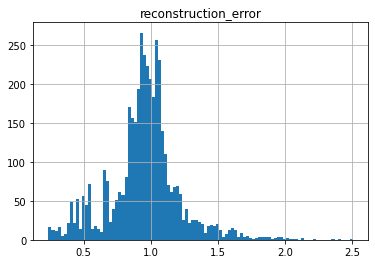

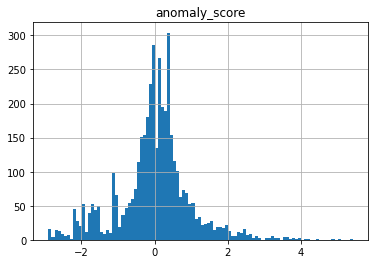

searching for outliers in length ...


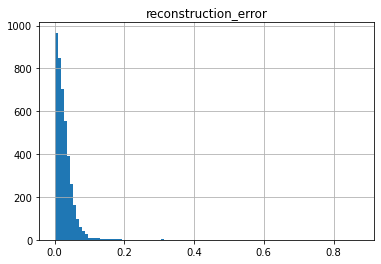

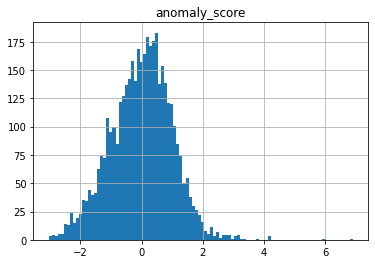

searching for outliers in diameter ...


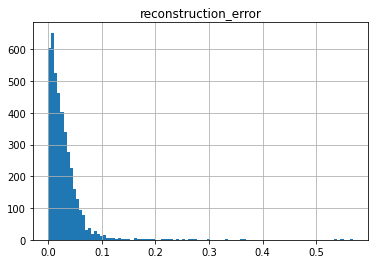

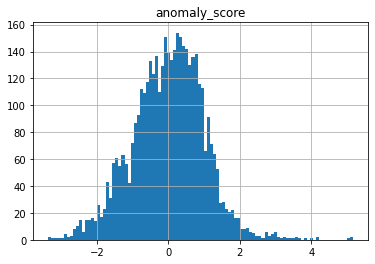

searching for outliers in height ...


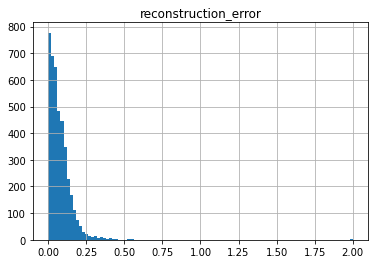

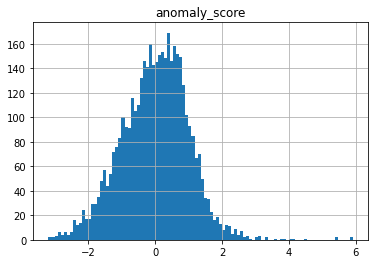

searching for outliers in whole_weight ...


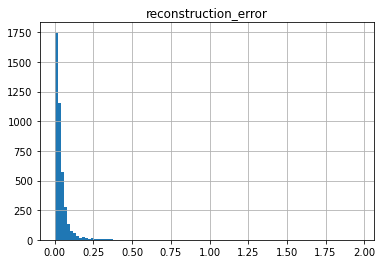

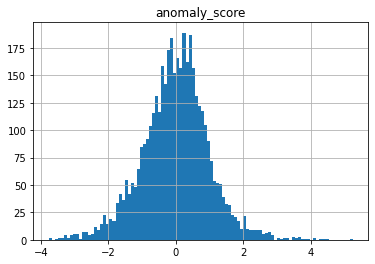

searching for outliers in shucked_weight ...


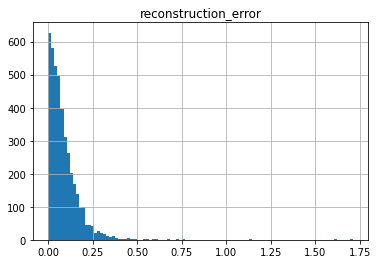

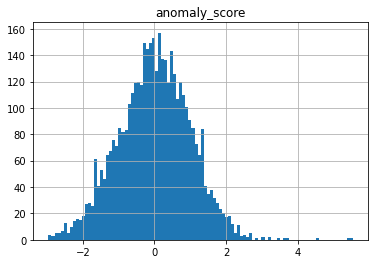

searching for outliers in viscera_weight ...


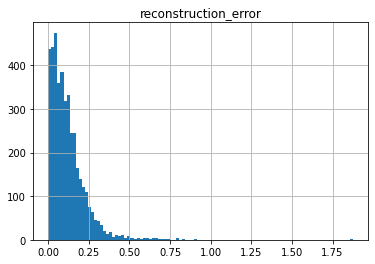

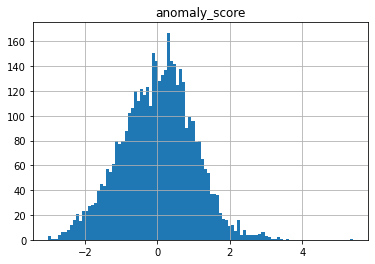

searching for outliers in shell_weight ...


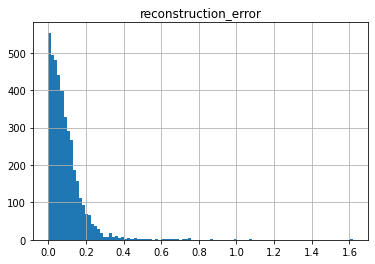

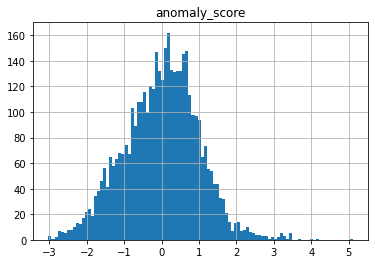

searching for outliers in rings ...


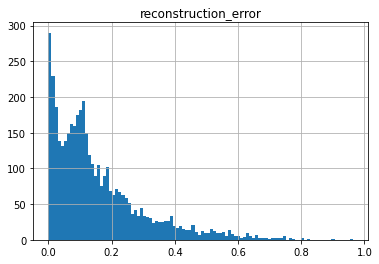

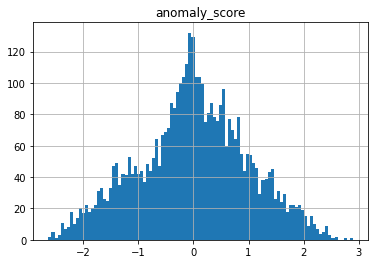

,current,pred,anomaly_score,column_name
1210,0.185,0.471472,6.907829,length
236,0.075,0.142659,5.939133,length
3996,0.0,0.1249,5.908057,height
1257,0.0,0.11001,5.908057,height
2627,0.495,0.038757,5.540516,shucked_weight
1174,0.015,0.159791,5.437408,height
3337,I,F,5.414521,sex
3522,0.0005,0.015369,5.394042,viscera_weight
1216,0.435,0.047037,5.385804,shucked_weight
2051,1.13,0.12051,5.374721,height


total_changes_made: 71 iteration execution time: 0:04:41.436825
searching for outliers in sex ...
searching for outliers in length ...
searching for outliers in diameter ...
searching for outliers in height ...
searching for outliers in whole_weight ...
searching for outliers in shucked_weight ...
searching for outliers in viscera_weight ...
searching for outliers in shell_weight ...
searching for outliers in rings ...
total_changes_made: 99 iteration execution time: 0:05:06.736295
searching for outliers in sex ...
searching for outliers in length ...
searching for outliers in diameter ...
searching for outliers in height ...
searching for outliers in whole_weight ...
searching for outliers in shucked_weight ...
searching for outliers in viscera_weight ...
searching for outliers in shell_weight ...
searching for outliers in rings ...
total_changes_made: 130 iteration execution time: 0:05:18.427847
searching for outliers in sex ...
searching for outliers in length ...
searching for outl

In [38]:
%%time

fixed_df, report = fix_dataset(
    init_df=abalone, 
    max_n_changes=max_n_changes, 
    anomaly_thresh=anomaly_thresh, 
    ignore_columns=ignore_columns,
    k_folds=k_folds,
    plot=True
)

In [39]:
changes = get_changes(abalone_back, fixed_df, ignore_columns=ignore_columns)
changes

,column_name,current_value,new_value
90,whole_weight,0.8115,0.824684
91,diameter,0.44,0.429108
118,rings,9,10.440541
123,sex,M,I
132,sex,F,I
...,...,...,...
3996,height,0.0,0.1249
3996,whole_weight,0.134,0.382351
3996,shucked_weight,0.0575,0.221334
3996,shell_weight,0.3505,0.107063


In [40]:
changes = get_changes(abalone, fixed_df, ignore_columns=ignore_columns)
changes

,column_name,current_value,new_value
90,whole_weight,100.0,0.824684
91,diameter,NO_VALUE,0.429108
118,rings,NO_VALUE,10.440541
123,sex,M,I
132,sex,F,I
...,...,...,...
3996,height,0.0,0.1249
3996,whole_weight,0.134,0.382351
3996,shucked_weight,0.0575,0.221334
3996,shell_weight,0.3505,0.107063


In [41]:
changes.shape[0]

135

# changed value marked as anomaly and fixed
## it has 90 row index

In [42]:
import json

In [43]:
# show report
print(json.dumps(report, indent=2))

{
  "info": {
    "max_n_changes": 135,
    "anomaly_thresh": 4.0,
    "k_folds": 5,
    "reg_quantiles": 20,
    "random_state": 0,
    "n_rows": 4177,
    "dtypes": {
      "index": "int64",
      "sex": "object",
      "length": "float64",
      "diameter": "float64",
      "height": "float64",
      "whole_weight": "float64",
      "shucked_weight": "float64",
      "viscera_weight": "float64",
      "shell_weight": "float64",
      "rings": "float64"
    },
    "ignore_columns": [
      "index"
    ],
    "regression_columns": [
      "length",
      "diameter",
      "height",
      "whole_weight",
      "shucked_weight",
      "viscera_weight",
      "shell_weight",
      "rings"
    ],
    "classification_columns": [
      "sex"
    ],
    "iterative_outliers_fix": [
      {
        "0": {
          "index": 1210,
          "current": 0.185,
          "pred": 0.4714722367875936,
          "anomaly_score": 6.907828890998803,
          "column_name": "length"
        },
        "

In [44]:
with open('report.json', 'w', encoding='utf-8') as f:
    json.dump(report, f, ensure_ascii=False, indent=2)

In [45]:
dt_end = datetime.utcnow()
print(dt_end)
print(f'total execution time: {dt_end - dt_start}')

2023-01-19 05:22:16.081097
total execution time: 0:25:28.543823


# environment (just for reference)
## this is last cell

In [46]:
!conda list

# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
abseil-cpp                20211102.0           h27087fc_1    conda-forge
absl-py                   0.15.0                   pypi_0    pypi
accelerate                0.12.0                   pypi_0    pypi
access                    1.1.8                    pypi_0    pypi
affine                    2.3.1                    pypi_0    pypi
aiobotocore               2.4.2                    pypi_0    pypi
aiohttp                   3.8.1            py37h540881e_1    conda-forge
aioitertools              0.11.0                   pypi_0    pypi
aiosignal                 1.2.0              pyhd8ed1ab_0    conda-forge
albumentations            1.3.0                    pypi_0    pypi
alembic                   1.9.1                    pypi_0    py